In [ ]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## **Load and Preprocess Dataset**

In [ ]:
path = Path("/content/drive/MyDrive/COVID-19_Radiography_Dataset")

root_dir = path.glob("*")

label_encoder = {
    "Viral Pneumonia": 0,
    "COVID": 1,
    "Normal": 2
}

label_decoder = {
    0: "Viral Pneumonia",
    1: "COVID",
    2: "Normal"
}

In [ ]:
image_data = {
    0: [], 
    1: [], 
    2: []
}

for folder in root_dir:
    label = str(folder).split("/")[-1]

    print(folder)

    for img_path in folder.glob("*.png"):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)/255.0
        image_data[label_encoder[label]].append(img_array) 

    # print(len(image_data[label_encoder[label]]))

/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia
/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID
/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal


In [ ]:
print(image_data[0][0])

[[[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.10588235 0.10588235 0.10588235]
  [0.08627451 0.08627451 0.08627451]
  [0.07058824 0.07058824 0.07058824]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.09411765 0.09411765 0.09411765]
  [0.08235294 0.08235294 0.08235294]
  [0.0627451  0.0627451  0.0627451 ]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.08235294 0.08235294 0.08235294]
  [0.07843138 0.07843138 0.07843138]
  [0.0627451  0.0627451  0.0627451 ]]

 ...

 [[0.         0.         0.        ]
  [0.00784314 0.00784314 0.00784314]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]


In [ ]:
def drawImg(img, label):
    plt.title(label_decoder[label])
    # plt.axis("off")    
    plt.imshow(img)
    plt.show()

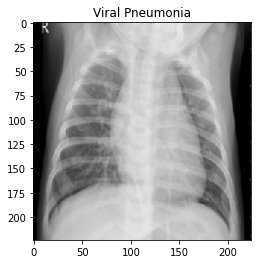

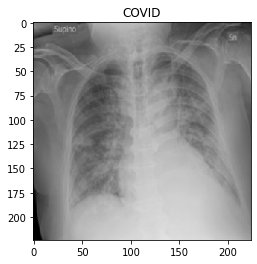

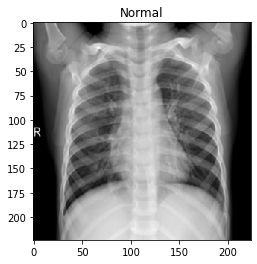

In [ ]:
drawImg(image_data[0][0], 0)
drawImg(image_data[1][0], 1)
drawImg(image_data[2][0], 2)

## **Adaptive Histogram Equalization**

In [ ]:
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [ ]:
N_CLASSES = 3
for i in range(N_CLASSES):
    for j in range(len(image_data[i])):
        image_data[i][j] = AHE(image_data[i][j])

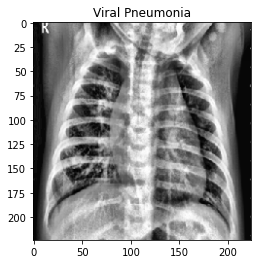

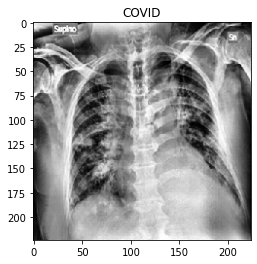

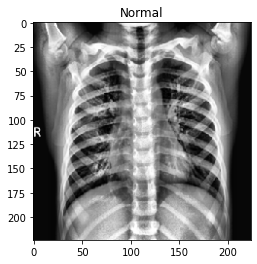

In [ ]:
drawImg(image_data[0][0], 0)
drawImg(image_data[1][0], 1)
drawImg(image_data[2][0], 2)

## **Data Visualization**

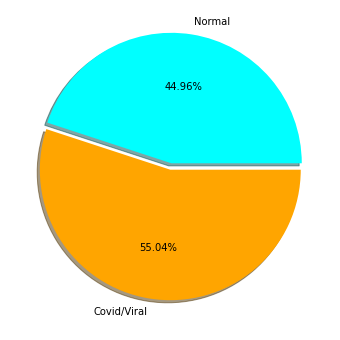

In [ ]:
plt.figure(figsize=(8, 6))
plt.pie(x = [len(image_data[2]), len(image_data[0]) + len(image_data[1])], labels = ["Normal", "Covid/Viral"], autopct = "%1.2f%%", shadow=True, colors = ["cyan", "orange"], explode=(0.05,0))
plt.show()

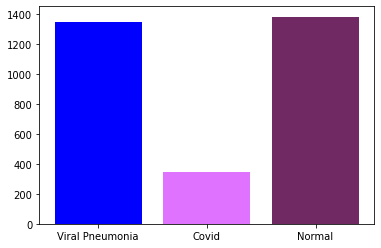

In [ ]:
# Count PLot
plt.bar(x = ["Viral Pneumonia", "Covid", "Normal"], height = [len(image_data[0]), len(image_data[1]), len(image_data[2])], color = ["blue", "#df73ff", "#702963"])
plt.show()

## **Test-Train-Validation Split**

In [ ]:
# N_CLASSES = 3
for i in range(N_CLASSES):
    random.shuffle(image_data[i])

In [ ]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.1

X_train = []
Y_train = []

X_test = []
Y_test = []

X_val = []
Y_val = []

# [test.....val......train]

for i in range(N_CLASSES):
    l = int(TEST_SPLIT * len(image_data[i]))
    r  = int(VALIDATION_SPLIT * (len(image_data[i]) - l))

    for k in range(l):
        X_test.append(image_data[i][k])      
        Y_test.append(i)
    for k in range(l, l + r):
        X_val.append(image_data[i][k])  
        Y_val.append(i);
    for k in range(l + r, len(image_data[i])):
        X_train.append(image_data[i][k])  
        Y_train.append(i);

In [ ]:
print(len(X_test)) 
print(len(Y_test))
print(len(X_val)) 
print(len(Y_val))
print(len(X_train)) 
print(len(Y_train))

614
614
244
244
2218
2218


In [ ]:
def combine_shuffle(X, Y):
    combined = list(zip(X, Y))
    random.shuffle(combined)
    X[:], Y[:] = zip(*combined)
    return X, Y

In [ ]:
X_test, Y_test   = combine_shuffle(X_test, Y_test)
X_val, Y_val     = combine_shuffle(X_val, Y_val)
X_train, Y_train = combine_shuffle(X_train, Y_train)

In [ ]:
X_test  = np.array(X_test)
Y_test  = np.array(Y_test)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val   = np.array(X_val)
Y_val   = np.array(Y_val)

## **Data Augmentation**

In [ ]:
# Augment Covid images to Train Set only
X_train_covid = []
for i in range(len(X_train)):
    if label_decoder[Y_train[i]] == "COVID":
        X_train_covid.append(X_train[i])

X_train_covid = np.array(X_train_covid)
print(X_train_covid.shape)

(252, 224, 224, 3)


In [ ]:
datagen = ImageDataGenerator(rotation_range=0.05, shear_range=0.05, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.01, rescale=1./255)

In [ ]:
X_aug = []
Y_aug = []

In [ ]:
datagen.fit(X_train_covid)

In [ ]:
for images, labels in zip(datagen.flow(X_train_covid), range(25)): #15 
    for img in images:
        img = np.array(img)*255.0
        X_aug.append(img)
        Y_aug.append(label_encoder["COVID"])

In [ ]:
print(len(X_aug))
print(len(Y_aug))

788
788


In [ ]:
for i in range(len(X_aug)):
    X_aug[i] = AHE(X_aug[i])

In [ ]:
for i in range(len(X_train)):
    if label_decoder[Y_train[i]] != "COVID":
        X_aug.append(X_train[i])
        Y_aug.append(Y_train[i])

In [ ]:
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)
print(type(X_aug))
print(len(X_aug))
print(type(Y_aug))
print(len(Y_aug))

<class 'numpy.ndarray'>
2754
<class 'numpy.ndarray'>
2754


In [ ]:
X_train, Y_train = X_aug, Y_aug

In [ ]:
X_train, Y_train = combine_shuffle(X_train, Y_train)

## **Build a Model**

In [ ]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

### **CNN**

In [ ]:
# Create the Model
def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
model = createModel()

In [ ]:
# Compile the Mddel
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)       

In [ ]:
# Train the Model
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

hist = model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_val, Y_val), callbacks=[checkpoint]) 

Epoch 1/50
70/70 [==============================] - 3s 32ms/step - loss: 1.0512 - accuracy: 0.4156 - val_loss: 0.9421 - val_accuracy: 0.6844
Epoch 2/50
70/70 [==============================] - 2s 27ms/step - loss: 0.9879 - accuracy: 0.4602 - val_loss: 0.9029 - val_accuracy: 0.6598
Epoch 3/50
70/70 [==============================] - 2s 27ms/step - loss: 0.8918 - accuracy: 0.5599 - val_loss: 0.6365 - val_accuracy: 0.7664
Epoch 4/50
70/70 [==============================] - 2s 27ms/step - loss: 0.7054 - accuracy: 0.6993 - val_loss: 0.5312 - val_accuracy: 0.7459
Epoch 5/50
70/70 [==============================] - 2s 27ms/step - loss: 0.5590 - accuracy: 0.7854 - val_loss: 0.3570 - val_accuracy: 0.8770
Epoch 6/50
70/70 [==============================] - 2s 27ms/step - loss: 0.5067 - accuracy: 0.8230 - val_loss: 0.3058 - val_accuracy: 0.8934
Epoch 7/50
70/70 [==============================] - 2s 27ms/step - loss: 0.4279 - accuracy: 0.8503 - val_loss: 0.2943 - val_accuracy: 0.9016
Epoch 8/50
70

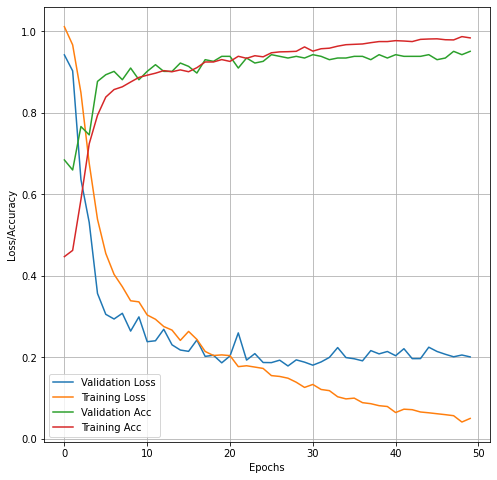

In [ ]:
h = hist.history

plt.figure(figsize=(8, 8))
plt.plot(h['val_loss'], label="Validation Loss")
plt.plot(h['loss'], label="Training Loss")
plt.plot(h['val_accuracy'], label="Validation Acc")
plt.plot(h['accuracy'], label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")

plt.grid(None)
plt.legend()
plt.show()

In [ ]:
# Load best weights
model.load_weights("best_model.h5")

In [ ]:
# Compute Test Accuracy
performance = model.evaluate(X_test, Y_test)
acc_ = round(performance[1]*100, 3)
print(performance)

20/20 [==============================] - 0s 13ms/step - loss: 0.1771 - accuracy: 0.9495
[0.17707444727420807, 0.9495114088058472]


### **VGG-16 (Transfer Learning)**

In [ ]:
# Create the Model
def createModelVGG():
    base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    gap = GlobalAveragePooling2D()(base_model.output)
    fc1 = Dense(256, activation='relu')(gap)
    drop1 = Dropout(0.5)(fc1)
    fc2 = Dense(64, activation='relu')(drop1)
    drop2 = Dropout(0.5)(fc2)
    fc3 = Dense(3, activation='softmax')(drop2)

    model = Model(inputs=base_model.input, outputs=fc3)
    return model

In [ ]:
modelVGG = createModelVGG()

In [ ]:
for i in range(len(modelVGG.layers)):
    print(i, modelVGG.layers[i])

for i in range(17):
    modelVGG.layers[i].trainable = False

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc607f96e10>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f96cd0>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f60f90>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc60381d450>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f965d0>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607eedf50>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc608057790>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f5aad0>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f01750>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc603847d50>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc607f72150>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc607f03710>
12 <tensorflow.python.ke

In [ ]:
# Compile the Model
adam = Adam(learning_rate=0.0003)
modelVGG.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelVGG.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
# Train the Model
checkpoint = ModelCheckpoint("best_model_VGG.h5", monitor='val_accuracy', save_best_only=True)

hist = modelVGG.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=11, batch_size=32, callbacks=[checkpoint])

Epoch 1/11
70/70 [==============================] - 19s 263ms/step - loss: 0.9873 - accuracy: 0.5206 - val_loss: 0.4308 - val_accuracy: 0.8566
Epoch 2/11
70/70 [==============================] - 18s 258ms/step - loss: 0.5014 - accuracy: 0.8009 - val_loss: 0.3585 - val_accuracy: 0.8811
Epoch 3/11
70/70 [==============================] - 18s 260ms/step - loss: 0.3422 - accuracy: 0.8753 - val_loss: 0.2977 - val_accuracy: 0.9098
Epoch 4/11
70/70 [==============================] - 18s 260ms/step - loss: 0.2780 - accuracy: 0.9093 - val_loss: 0.2081 - val_accuracy: 0.9262
Epoch 5/11
70/70 [==============================] - 18s 260ms/step - loss: 0.2339 - accuracy: 0.9267 - val_loss: 0.2300 - val_accuracy: 0.8934
Epoch 6/11
70/70 [==============================] - 18s 260ms/step - loss: 0.2144 - accuracy: 0.9254 - val_loss: 0.1619 - val_accuracy: 0.9344
Epoch 7/11
70/70 [==============================] - 18s 260ms/step - loss: 0.1662 - accuracy: 0.9453 - val_loss: 0.1509 - val_accuracy: 0.9262

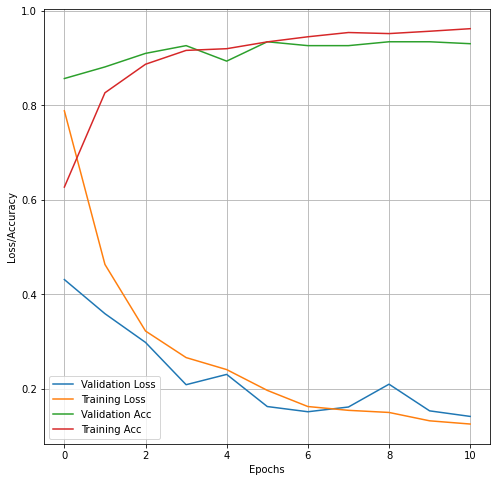

In [ ]:
h = hist.history

plt.figure(figsize=(8, 8))
plt.plot(h['val_loss'], label="Validation Loss")
plt.plot(h['loss'], label="Training Loss")
plt.plot(h['val_accuracy'], label="Validation Acc")
plt.plot(h['accuracy'], label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")

plt.grid(None)
plt.legend()
plt.show()

In [ ]:
# Load best weights
modelVGG.load_weights("best_model_VGG.h5")

# **Results**

In [ ]:
# Compute Test Accuracy
performanceVGG = modelVGG.evaluate(X_test, Y_test)
acc_VGG = round(performanceVGG[1]*100, 3)
print(performanceVGG)

20/20 [==============================] - 4s 222ms/step - loss: 0.1201 - accuracy: 0.9756
[0.12013112008571625, 0.975570023059845]


In [ ]:
# Perform Prediction
Y_pred = [np.argmax(pred) for pred in modelVGG.predict(X_test)]
Y_pred = np.array(Y_pred)

In [ ]:
# Classification Report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       269
           1       1.00      0.94      0.97        69
           2       0.96      0.99      0.97       276

    accuracy                           0.98       614
   macro avg       0.98      0.97      0.97       614
weighted avg       0.98      0.98      0.98       614



In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap="BuPu", normalize=True):
    """
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

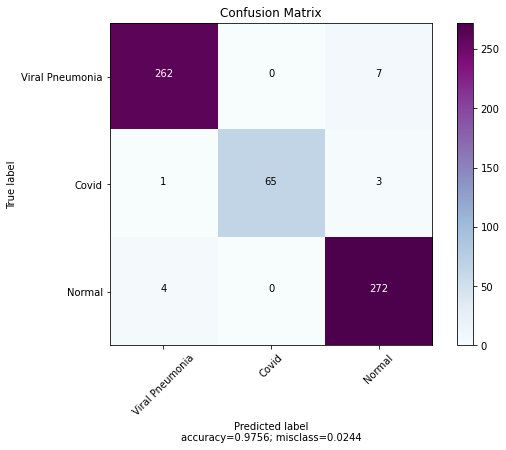

In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm           = cm, 
                      normalize    = False,
                      target_names = ['Viral Pneumonia', 'Covid', 'Normal'],
                      title        = "Confusion Matrix")

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You c

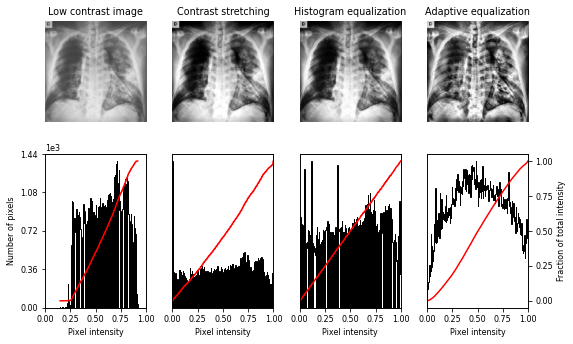

In [ ]:
# Image Enhancement Techniques
import matplotlib
from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    # ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = img_array

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
# why AHE? 
# it smoothens the curve (no of pixels vs pixel intensity)
# Basic HE (blndly equalize the pixel intensity) (breaks/discontinuities/sharp curve)

# **Web App**

In [ ]:
from google.colab import files

def upload_and_predict():
    uploaded_img = files.upload()

    img_path = '/content/' + list(uploaded_img.keys())[0]

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)/255.0
    img_np = np.array(img_array)

    print(img_np.shape)
    imag_dim_ing = []
    imag_dim_ing.append(img_np)
    imag_dim_ing = np.array(imag_dim_ing)

    pred = modelVGG.predict(imag_dim_ing)
    # print(img_np)

    plt.imshow(img_np)
    plt.show()
    print(label_decoder[np.argmax(pred[0])])

Saving Viral Pneumonia-480.png to Viral Pneumonia-480.png
(224, 224, 3)


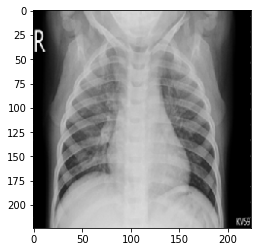

Viral Pneumonia


In [ ]:
upload_and_predict()